# Using EasyVVUQ to generate training data for a forward-UQ  Machine-Learning surrogate

Let's start with some definitions:

* Forward uncertainty propagation: computing the output distribution of a computational model, given *assumed* probability density functions for the input parameters of the model (see image below). 

* [EasyVVUQ](https://github.com/UCL-CCS/EasyVVUQ) is VECMA's forward uncertainty propagation toolkit.

* Forward surrogate model: an approximation of the input-output map, which can be evaluated at a fraction of the cost of the computational model. 

* [EasySurrogate](https://github.com/wedeling/EasySurrogate) is VECMA's surrogate modelling toolkit.

![](images/forward.png)

### Goal 

Use EasyVVUQ to generate supervised (input parameter, code output) training data on which to train a machine-learning (ML) type of surrogate model. In addition we will

* Review some theory behind the sparse-grid methods of EasyVVUQ a ML-method of EasySurrogate.
* Briefly discuss when you might use ML for building surrogate models.

## Installation

* EasyVVUQ: via git clone or `pip install easyvvuq`

* EasySurrogate: via git clone or `pip install easysurrogate`

In [1]:
!pip install easyvvuq

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## Sparse-grid UQ in theory

### Making a interpolation-based surrogate with 1 uncertain input parameter


Let $f^{(1)}(x)$ be a one-dimensional function. We aim to create an interpolation of $f^{(1)}$, denoted by

\begin{align}
 I^{(l)}f^{(1)}(x) = \sum_{i=1}^{m_l} f(x_{i}^{(l)})a^{(l)}_i(x).
 \label{eq:sc1d}
\end{align}

Here, $l$ is the so-called *level* of the interpolant. It is an index which links to a **one-dimensional** set of collocation points $\{x^{l}_i\}$, for $i=1,\cdots, m_l$. We can select these points from different families, typically they'll be the abscissas of some quadrature rule. For instance, a Clenshaw-Curtis (CC) rule can generate different collocation points in $[0,1]$ such that

* Level 1: $x^{(1)}_i \in \{0.5\}$,
* Level 2: $x^{(2)}_i \in \{0.0, 0.5, 1.0\}$,
* Level 3: $x^{(3)}_i \in \{0.0, 0.146, 0.5, 0.854, 1.0\}$.

Note that here, the higher level collocation point sets include all points from previous levels. When this is the case, we say that the quadrature rule is **nested**. This leads to efficient sampling plans in higher dimensions, but nestedness is not a strict requirement for sparse grid interpolation or integration. This does lead to 1D quadrature rules which increase exponentially, such that the number of points is given by

\begin{align}
 m_l = 
 \begin{cases}
  2^{l-1} + 1 & l > 1 \\
  1 & l = 1
 \end{cases}  
\end{align}

Finally, the $a^{(l)}_i(x)$ are the basis functions used for interpolation. In the case of the **Stochastic Collocation** (SC) method, these are often (although not necessarily) the Lagrange interpolation polynomials, given by

\begin{align}
a^{(l)}_i(x) = \prod_{\substack{1\leq j \leq m_l \\ j \neq i}} \frac{x - x_j}{x_i - x_j}
\end{align}

A property of the Lagrange polynomial associated with the i-th collocation point is that $a^{(l)}_i(x_i) = 1$ at this point, and $a^{(l)}_i(x_j) = 0$ at all other collocation points $x_j$. The interpolation $I^{(l)}f^{(1)}$ will therefore exactly reproduce the code outputs $f^{(1)}(x_i)$ at the collocation points $x_i$.

### Refinement

Let us define the following difference formulas for interpolation in 1D:

\begin{align}
 \Delta^{(l)} f^{(1)} := I^{(l)}f^{(1)} - I^{(l-1)}f^{(1)}\quad\mathrm{where}\quad
 I^{(0)}f^{(1)}:=0.
 \label{eq:Delta1d}
\end{align}

That is, $ \Delta^{(l)} f^{(1)}$ is just the difference between the interpolations at successive levels. These difference formulas are often used in both sparse-grid interpolation (and quadrature), see the figure below.

![](images/fig1.png)


When interpolating a level $l-1$ interpolant using a level $l$ interpolating we retrieve the former, i.e.

\begin{align}
 I^{(l)}\left(I^{(l-1)}f^{(l)}\right) = I^{(l-1)}f^{(l)}.
\end{align}


Thus, a lower level interpolant can be exactly interpolated by a higher level interpolant (which is true for both nested and non-nested collocation points), see Figure below:

![](images/fig2.png)
*The blue solid line is the exact 1D function $f^{(1)}$. The red striped line is a (non-nested) level $l$ interpolant. The green striped line is a lower-level $l-1$ counterpart, constructed from function evaluations at  the green star symbols.. If we evaluate the level $l-1$ interpolant at the level $l$ collocation, we obtain the blue squares. Clearly, if these function values are used to construct a level $l$ interpolant of $I^{(l-1)}f^{(1)}$, which would be $I^{(l)}\left(I^{(l-1)}f^{(1)}\right)$, we just retrieve $I^{(l-1)}f^{(1)}$.*

We can therefore write the difference formula as

\begin{align}
 \Delta^{(l)}f^{(1)} = I^{(l)}f^{(1)} - I^{(l-1)}f^{(1)} =  I^{(l)}f^{(1)} - I^{(l)}\left(I^{(l-1)}f^{(1)}\right) = \sum_{i = 1}^{m_l}f(x^{(l)}_i)a^{(l)}_i - \sum_{i=1}^{m_l}I^{(l-1)}f^{(1)}(x^{(l)}_i)a^{(l)}_i = \nonumber\\
 \sum_{i=1}^{m_l}\left[f(x^{(l)}_i) - I^{(l-1)}f^{(1)}(x^{(l)}_i)\right]a^{(l)}_i = \sum_{i=1}^{m_l}w^{(l)}_ia^{(l)}_i.
 \label{eq:diff0}
\end{align}

Here, $w^{(l)}_i:=f(x^{(l)}_i) - I^{(l-1)}f^{(1)}(x^{(l)}_i)$ is the **hierarchical surplus**, defined as the difference between the code output at a collocation point $x^{(l)}_i$ at level $l$, minus the level $l-1$ polynomial approximation of the code output at the same location. This can be thought of as a local measure of the accuracy of the interpolation. Furthermore, we can also write the interpolation $I^{(l)}f^{(1)}(x)$ in terms of the difference formulas, in which case the $a^{l}_i$ basis function will form a hierarchical basis as

\begin{align}
 I^{(L)}f^{(1)} = \sum_{l=1}^L \Delta^{(l)}f^{(1)} = \sum_{l=1}^L\sum_{i=1}^{m_l}w^{(l)}_i a^{(l)}_i
 \label{eq:diff1}
\end{align}

Hence, to obtain a level $L$ interpolant, we can just create a telescopic sum of the difference formulas, which is the first equality above. The second equality is obtained by simply plugging in the formula for $\Delta^{(l)}f^{(1)}$, and it shows that the $a^{(l)}_i$ form a hierarchical basis due to summation over $l$, which increases the number collocation point $m_l$ at every new level. This is also sketched in the Figure below, which assumes linear basis functions for simplicity.

![](images/fig3.png)
*Top left is a standard linear (finite-element) basis, with below it a corresponding linear interpolant. Top right displays a linear hierarchical basis. Below it we show a series of 3 hierarchical interpolants ($L=1,2$ and $3$) and the hierarchical surplus coefficients $w^{(l)}_i$ used in their construction. Figure recreated from*

**Why should we care?**

The formula above is the same as $I^{(l)}f^{(1)}$ in the beginning, as both are 1D interpolation formulas, only written differently, so why should we complicate things with a hierarchical notation? 

One advantage of adopting the hierarchical notation is that it naturally allows for **refinement**, i.e. adding more points to an existing sampling plan, by adding another level. If we select a nested quadrature rule, adding another level means we only have to evaluate the (expensive) code at a relatively small number of *new* points, the other points are quaranteed to be present in one or more of the previous levels, see the CC example at the beginning of this section.

In the case more than one uncertain input, sampling plans are create using **tensor products of 1D collocation points**. Here, **a hierarchical construction leads to a sparse sampling plan**, with much less code evaluations compared to "standard" sampling plans.

![](images/drawing.png)

## Sparse-grid UQ in practice

### Model description

Let's review the basic model. It is a simulation of a vertical deflection of a round metal 
tube suspended on each end in response to a force applied at certain point ```a``` along its length. 
Our goal is to determine the influence of the input parameters on the vertical deflection at point ```a```.

The usage of the application is:

```beam <input_file>```

It outputs calculated displacements to a file called `output.json`. Its content will look like 

```{'g1': x, 'g2': y, 'g3': y}```

In order to produce statistically significant results, EasyVVUQ needs to run a number of model evaluations
 appropriately selecting input arguments from a given sample parameter space. 
 Once selected, input parameters need to be transformed into a format understandable by the application. 
Our application takes a single file as an input and the transformation may be based on a single template file,
called `beam.template`, with the following content:

```{"outfile": "$outfile", "F": $F, "L": $L, "a": $a, "D": $D, "d": $d, "E": $E}```

The template will be used to generate files called `input.json` that will be the input to each run of beam.
All placeholders (signified by the $ delimeter) will be replaced by concrete values from the sample parameter space. 

<img src="images/simply_supported_beam.png" width="500" height="300" />

The tube has an inner and outer diameter

<img src="images/tube-diameters.png" width="200" height="100" />

The parameters are self explanatory, and the model is just a simple analytical function, which can be found [here](https://openturns.github.io/openturns/latest/usecases/use_case_deflection_tube.html).

In [2]:
import os
import numpy as np
import easyvvuq as uq
import chaospy as cp
import matplotlib.pyplot as plt
from easyvvuq.actions import CreateRunDirectory, Encode, Decode, ExecuteLocal, Actions

In [3]:
# the directory in which the code samples will be stored
WORK_DIR = '/tmp'

In [8]:
# specify the parameters
params = {
    "F": {"type": "float", "default": 1.0}, 
    "L": {"type": "float", "default": 1.5}, 
    "a": {"type": "float", "min": 0.7, "max": 1.2, "default": 1.0}, 
    "D": {"type": "float", "min": 0.75, "max": 0.85, "default": 0.8},
    "d": {"type": "float", "default": 0.1},
    "E": {"type": "float", "default": 200000},
    "outfile": {"type": "string", "default": "output.json"}
}

Below we create the encoder and decoder objects that are capable of reading the input and output files that are described above.

In [9]:
encoder = uq.encoders.GenericEncoder(template_fname='beam.template', delimiter='$', target_filename='input.json')
decoder = uq.decoders.JSONDecoder(target_filename='output.json', output_columns=['g1'])

As our model is a toy problem, we can execute it locally:

In [10]:
execute = ExecuteLocal('{}/beam input.json'.format(os.getcwd()))

However, in many cases the model will be too expensive for local executing. In this case the VECMA tools [QCG-PilotJob](https://github.com/vecma-project/QCG-PilotJob) or [FabSim3](https://github.com/djgroen/FabSim3) can be used in combination with EasyVVUQ to submit the ensemble to HPC resources.

Now we are combine all actions we want to execute into an Actions object.

In [11]:
actions = Actions(CreateRunDirectory(root=WORK_DIR, flatten=True), Encode(encoder), execute, Decode(decoder))

An EasyVVUQ campaign is created, and the parameters and actions are supplied to it.

In [12]:
campaign = uq.Campaign(name='beam_SC', params=params, actions=actions)

We simply copy the input distributions from [here](https://openturns.github.io/openturns/latest/usecases/use_case_deflection_tube.html):


* F: Normal(1,0.1)
* L: Normal(1.5,0.01)
* a: Uniform(0.7,1.2)
* D: Triangular(0.75,0.8,0.85)
* d: Triangular(0.09,0.1,0.11)
* E: Normal(200000,2000)

Let's start with just 2 inputs, and visualize the sparse grid. 

In [14]:
# specify the input distributions of the parameters that we which to vary
vary = {
    "a": cp.Uniform(0.7, 1.2),
    "D": cp.Triangle(0.75, 0.8, 0.85),
}

Here we select the (sparse) Stochastic Collocation sampler. Increase the `polynomial_order` of the sampler object below to create sparse grids with more levels. Also compare this to a standard non-sparse sampling plan by setting `sparse=False`.

Number of sampling points = 1


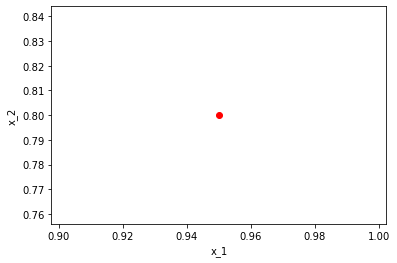

In [15]:
sampler = uq.sampling.SCSampler(vary=vary, polynomial_order=1, quadrature_rule='C', growth=True, sparse=True)
campaign.set_sampler(sampler)

# plot the sampling plan of the (first) two input dimensions
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='x_1', ylabel='x_2')
# the xi_d array contains the N x d sampling points, with N being the number of points and d the number of inputs
ax.plot(sampler.xi_d[:,0], sampler.xi_d[:, 1], 'ro')
# print the number of points to screen
print("Number of sampling points = %d" % sampler.n_samples)

The command below executes the ensemble and collects the results from the output files.

Number of sampling points = 1537


100%|██████████| 832/832 [00:38<00:00, 21.82it/s]


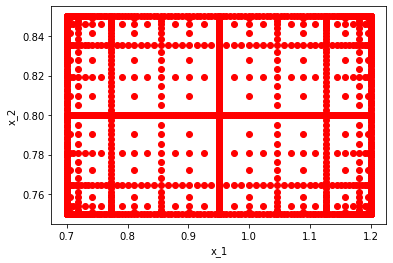

In [35]:
refine = True
if refine:
    sampler.next_level_sparse_grid()
    # plot the sampling plan of the (first) two input dimensions
    fig = plt.figure()
    ax = fig.add_subplot(111, xlabel='x_1', ylabel='x_2')
    # the xi_d array contains the N x d sampling points, with N being the number of points and d the number of inputs
    ax.plot(sampler.xi_d[:,0], sampler.xi_d[:, 1], 'ro')
    # print the number of points to screen
    print("Number of sampling points = %d" % sampler.n_samples)
# execute ensemble
campaign.execute().collate(progress_bar=True)

In [27]:
data_frame = campaign.get_collation_result()

The command below peforms the analysis step by post-processing of the ensemble results.

In [28]:
results = campaign.analyse(qoi_cols=['g1'])

Let's plot some Sobol sensitivity indices

In [29]:
sobols_first = results.sobols_first()
param_names = sobols_first['g1'].keys()
sobols_first = np.array(list(sobols_first['g1'].values()))

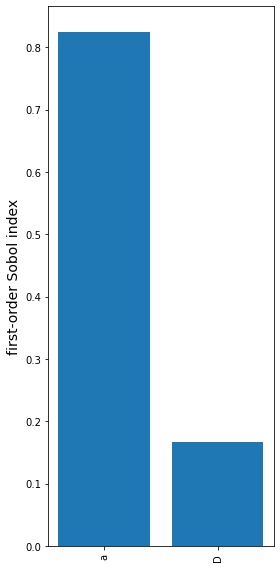

In [30]:
fig = plt.figure(figsize=[4, 8])
ax = fig.add_subplot(111)
ax.set_ylabel(r'first-order Sobol index', fontsize=14)
# find max quad order for every parameter
ax.bar(range(sobols_first.size), height=sobols_first.flatten())
ax.set_xticks(range(sobols_first.size))
ax.set_xticklabels(param_names)
plt.xticks(rotation=90)
plt.tight_layout()

Now, refine the grid multiple times to get an idea of the cost involved.

Notice that it can still become expensive, expecially for more than 2 inputs. So what can you do if you have 20, 30 or more inputs? One option is to still use a hierarchical sparse-grid construction, but try to refine only those inputs which have a significant impact on the output, see e.g. [5]. Here, we have refined all parameters to the same extent.

Another option, which will discuss below, is to use active subspaces to create a surrogate model, trained on input-output data.

## Active subspaces in theory


The Active Subspace method, introduced by [1], is a class of methods for forward propagation of uncertainty in high-dimensional input spaces. It attempts to circumvent the curse of dimensionality by dimension reduction of the input space. Specifically, it projects the input vector ${\bf x}\in\mathbb{R}^D$ to a lower-dimensional subspace ${\bf y}\in\mathbb{R}^d$, via a tall-and-skinny matrix $W_1\in\mathbb{R}^{D\times d}$ of orthogonal basis vectors, such that $W_1^TW_1 = I_d$, where $d<D$ and $I_d$ is the $d$-dimensional identity matrix. The active subspace is thus given by

\begin{align}
{\bf y} = W_1^T{\bf x} \in\mathbb{R}^d,
\label{eq:active}
\end{align}

where the main idea is that the dimension reduction simplifies the task of obtaining an accurate surrogate model. If we denote this surrogate by $g$, we thus want to find a model that satisfies

\begin{align}
f({\bf x})\approx g\left({\bf y}\right) = g\left(W_1^T{\
\bf x}\right).
\label{eq:g}
\end{align}

![](images/contours4.png)

*Although this function has 2 inputs, most of the variability occurs along a single direction (blue arrow) making the function effectively (almost) one dimensional*

### Classical means of finding $W_1$

Because ${\bf y}$ is a linear transformation of the inputs ${\bf x}$, it opens up the possibility of findings directions along which the model varies most. This is especially useful if a model varies significantly in a direction that is not aligned with the coordinate axes of ${\bf x}$. In "classical" active subspaces, dimension reduction is achieved by rotating the coordinate system such that it is aligned with the directions of most variability, after which only the most dominant directions are retained. To find these directions, the following average gradient matrix is constructed:

\begin{align}
 C = \int \left(\nabla f\left({\bf x}\right)\right)\left(\nabla f\left({\bf x}\right)\right)^T p(\bf x)d{\bf x}
 \label{eq:C}
\end{align}
\noindent
Here, $p({\bf x})$ is the chosen probability density function (pdf) of the inputs ${\bf x}$. Since $C$ is a symmetric, positive semi-definite matrix, it has the following spectral decomposition

\begin{align*}
 C = [W_1 W_2]\left[
\begin{matrix}
\Lambda_1 & 0 \\
0 & \Lambda_2
\end{matrix} 
 \right][W_1 W_2]^T.
\end{align*}

Hence the matrix $W_1$, used to project ${\bf x}$ to ${\bf y}$ in, are the first $d$ eigenvectors of $C$, which in turn correspond to the $d$ largest eigenvalues in $\Lambda_1$. These $d$ eigenvectors form an orthonormal basis aligned with the directions of most variability. Note that $C$ is averaged over $p({\bf x})$, and that in practise, the integral in in $C$ is often approximated using a Monte Carlo approach.

The approach described here is intuitive, and has nice theoretical properties, such as computable error bounds. The downside however, is that the gradient $\nabla f({\bf x})$ must be available. This requires the availability of an adjoint solver, or one must approximate the gradients using for instance finite differences. This downside has prompted the development of other active subspace methods which do not require access to the gradient. Some of these methods involve Gaussian processes, whereas others use deep learning. We will focus on the latter.

### Deep active subspaces

In [2], an approach is described in which artificial neural networks (ANNs) are used for $g$, and where $W_1$ is found using back propagation. Like the classical active subspace method, the construction ${\bf y} = W_1^T{\bf x}$ is retained. Moreover, the column vectors of $W_1$ still form an orthogonal basis. The difference is that the column vectors of $W_1$ are no longer the eigenvectors of the gradient matrix $C$, but instead are constructed using Gram-Schmidt orthogonalization. As such, $W_1$ is parametrized by a matrix $Q$ of the same dimension ($\in\mathrm{R}^{D\times d}$), where the non-orthonormal column vectors ${\bf q}_i\in\mathbb{R}^D$ are made orthonormal via

\begin{align}
 {\bf w}_i = {\bf q}_i - \sum_{j=1}^{i-1}\left(\frac{{\bf w}_j^T{\bf q}_i}{{\bf w}_j^T{\bf w}_j}\right){\bf w}_j, \quad i = 1,\cdots, d.
 \label{eq:GS}
\end{align}

That is, we start with ${\bf w}_1 := {\bf q}_1$, and for all subsequent vectors ${\bf q}_i$ we subtract the projections of ${\bf q}_i$ onto each vector ${\bf w}_j$ which has previously been orthogonalized. This leaves us with a orthogonal basis $ \left[{\bf w}_1({\bf q}_1)\;\;{\bf w}_2({\bf q}_1, {\bf q}_2)\;\;\cdots\;\;{\bf w}_d({\bf q}_1,{\bf q}_2\,\cdots,{\bf q}_d)\right]$. Finally, to obtain an orthonormal basis, each column vector is divided by its length. such that our final weight matrix becomes

\begin{align}
W_1(Q) = \left[\frac{{\bf w}_1({\bf q}_1)}{\lVert{\bf w}_1({\bf q}_1)\rVert_2}\;\;\frac{{\bf w}_2({\bf q}_1, {\bf q}_2)}{\lVert{\bf w}_2({\bf q}_1, {\bf q}_2)\rVert_2}\;\;\cdots\;\;\frac{{\bf w}_d({\bf q}_1,{\bf q}_2\,\cdots,{\bf q}_d)}{\lVert{\bf w}_d({\bf q}_1,{\bf q}_2\,\cdots,{\bf q}_d)\rVert_2}\right].
\label{eq:W1}
\end{align}

Note that the projection ${\bf y} = \Phi\left(W_1^T{\bf x}\right) = W_1^T{\bf x}$ also occurs in a layer of a neural network if the activation function $\Phi\left(\cdot\right)$ is linear. Thus, we can interpret the matrix $W_1$ as a weight matrix of the first hidden layer (with $d$ neurons and linear activation), connected to an input layer through which ${\bf x}$ is passed. Each column vector ${\bf w}_i$ contains the all weights connecting the input layer to the i-th neuron of the first hidden layer, see the figure below. Since the first hidden layer has only $d$ neurons, and its weight matrix is determined from a Gram-Schmidt procedure, we call the layer the Deep Active Subspace (DAS) layer.

<img src="images/nn1.png" width=700 height=700>

The surrogate $g({\bf y})$ is the ANN from the DAS layer onward, see the figure below. Each hidden layer has a weight matrix $W_i\in\mathbb{R}^{p + 1\times p}$, assuming that all hidden layers have $p$ neurons plus 1 bias neuron. As per usual, these weight matrices are optimized through the back propagation algorithm, in which the gradient $\partial L/\partial W_i$ is computed, where $L$ is the loss function.

<img src="images/nn2.png" width=700 height=700>

The situation in the DAS layer is different. Since $W_1=W_1(Q)$, we need to optimize $Q$ instead of the weight matrix, and therefore back propagation requires $\partial L/\partial Q$ instead of $\partial L/\partial W_1$. The authors of [2] suggest to use automatic differentiation. This does make sense, since although ${\bf w}_k/\Vert {\bf w}_k \rVert_2$ is algebraic and differentiable, it quickly becomes a complicated expression involving a very large number of $q_{ij}$ terms. Here, $q_{ij}$ are the $D$ entries, $i=1,\cdots,D$, of ${\bf q}_j$. That said, it is possible to use matrix calculus to find a simple expression for $\partial L /\partial Q$, which is the approach implemented in EasySurrogate.

## Deep active subspaces in practise

We will use EasyVVUQ with a Latin Hypercube (LHC) space filling design to sample the code. This will serve as training data for EasySurrogate. We will create a new campaign and LHC sampler, and reuse all previously defined `actions`.

In [36]:
# Now we'll use all 6 inputs
vary = {
    "F": cp.Normal(1, 0.1),
    "L": cp.Normal(1.5, 0.01),
    "a": cp.Uniform(0.7, 1.2),
    "D": cp.Triangle(0.75, 0.8, 0.85),
    "d": cp.Triangle(0.09, 0.1, 0.11),
    "E": cp.Normal(200000, 2000)
}

LHC_campaign = uq.Campaign(name='beam_LHC', params=params, actions=actions)
LHC_sampler = uq.sampling.quasirandom.LHCSampler(vary, max_num=500)
LHC_campaign.set_sampler(LHC_sampler)
LHC_campaign.execute().collate(progress_bar=True)

100%|██████████| 500/500 [00:23<00:00, 21.53it/s]


In [37]:
data_frame = LHC_campaign.get_collation_result()
data_frame

,run_id,iteration,F,L,a,D,d,E,outfile,g1
,0,0,0,0,0,0,0,0,0,0
0,1,0,1.329421,1.489054,1.045680,0.788183,0.105704,203428.841674,output.json,-0.000008
1,2,0,1.216001,1.498577,1.115272,0.807802,0.094288,202002.524204,output.json,-0.000006
2,3,0,0.835798,1.496655,1.162297,0.796109,0.104340,198553.883518,output.json,-0.000004
3,4,0,0.960515,1.486671,0.816257,0.764011,0.100693,201135.229479,output.json,-0.000010
4,5,0,1.129988,1.485850,1.049681,0.767948,0.092656,202526.833705,output.json,-0.000008
...,...,...,...,...,...,...,...,...,...,...
495,496,0,1.051242,1.490044,0.912759,0.806422,0.099093,202196.030332,output.json,-0.000008
496,497,0,0.914680,1.511702,0.791074,0.797670,0.103220,197248.677521,output.json,-0.000008
497,498,0,1.164355,1.495255,0.912602,0.782434,0.096325,199453.128451,output.json,-0.000010


Install EasySurrogate

In [38]:
!pip install easysurrogate

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


### Training

In [39]:
import easysurrogate as es

EasySurrogate has a design somewhat similar to EasyVVUQ. The main object is also a Campaign, and the different surrogate methods are the counterparts to the different samplers in EasyVVUQ. To create an EasySurrogate campaign, simply type:

In [41]:
surr_campaign = es.Campaign()

The EasySurrogate campaign can read the data (input paramater values and code samples) from an EasyVVUQ campaign:

In [42]:
# read the data input-output data from the LHC campaign 
params, samples = surr_campaign.load_easyvvuq_data(LHC_campaign, ['g1'])
# samples is a dict with the QoI names as keys. Turn it into an array
samples = samples['g1']

Extracting features ['F', 'L', 'a', 'D', 'd', 'E']
Extracting output data ['g1'] 


The `d` parameter (the dimension of the DAS layer, and thus the dimension of the active subspace) is a **hyperparameter that should be tuned**. Here we will just set it to 2.

In [43]:
# the total number of inputs
D = len(vary)
# the assumed dimension of the active subspace
d = 2

Here we create a DAS surrogate object and train it on the EasyVVUQ data. `n_iter` is the number of mini batch iterations, `n_layers` the number of layers, not counting the input layer, `n_neurons` is the number of neurons per hidden layer. Finally, `test_frac` is a number between 0 and 1 that reserves the last `test_frac` percent of the data for testing, thereby training the network on the first `1-test_frac` percent of the data.

In [44]:
surrogate = es.methods.DAS_Surrogate()
surrogate.train(params, samples, d, n_iter=10000, n_layers=4, n_neurons=100, test_frac = 0.2)

Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  400/500 samples to train the ML model
done preparing data
Neural net parameters
Number of layers = 4
Number of features = 6
Loss function = squared
Number of neurons per hidden layer = 100
Number of output neurons = 1
Activation hidden layers = tanh
Activation output layer = linear
This neural network has 10513 weights.
Training Deep Active Subspace Neural Network...
Batch 0 learning rate 0.001 loss: 1.9588007150898024
Batch 1000 learning rate 0.001 loss: 0.0013368452884311504
Batch 2000 learning rate 0.001 loss: 0.0006204851417346105
Batch 3000 learning rate 0.001 loss: 0.0005905625360575142
Batch 4000 learning rate 0.001 loss: 0.0006858901073589574
Batch 5000 learning rate 0.001 loss: 0.0010360559372736655
Batch 6000 learning rate 0.001 loss: 0.0006010517595439587
Batch 7000 learning rate 0.001 loss: 0.0004636478657205629
Batch 8000 learning rate 0.001 loss: 0.0005986264920977155
Batch 9000 learning rate 0.001 l

`dims` is a dictionary which contains useful dimensions of the DAS surrogate:

In [45]:
dims = surrogate.get_dimensions()
dims.keys()

dict_keys(['n_train', 'n_samples', 'n_test', 'D', 'd', 'n_out'])

### Prediction

We now test the accuracy of the surrogate on both the training and testing data

Relative error on training set = 0.0058
Relative error on test set = 0.0069


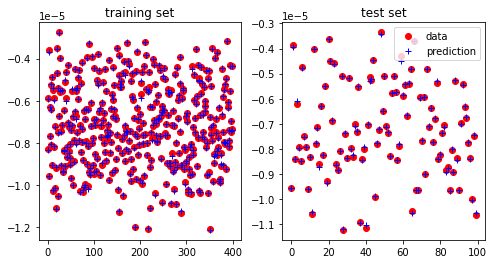

In [46]:
fig = plt.figure(figsize=[8, 4])

# run the trained model forward at training locations
n_mc = dims['n_train']
pred = np.zeros([n_mc, dims['n_out']])
for i in range(n_mc):
    pred[i,:] = surrogate.predict(params[i])
    
# compute the relative error using the training data
train_data = samples[0:dims['n_train']]
rel_err_train = np.linalg.norm(train_data - pred)/np.linalg.norm(train_data)

ax = fig.add_subplot(121, title='training set')
ax.plot(train_data, 'ro')
ax.plot(pred, 'b+')

# run the trained model forward at test locations
pred = np.zeros([dims['n_test'], dims['n_out']])
for idx, i in enumerate(range(dims['n_train'], dims['n_samples'])):
    pred[idx] = surrogate.predict(params[i])
test_data = samples[dims['n_train']:]

ax = fig.add_subplot(122, title='test set')
ax.plot(test_data, 'ro', label='data')
ax.plot(pred, 'b+', label='prediction')
ax.legend()

# compute the relative error using the test data
rel_err_test = np.linalg.norm(test_data - pred)/np.linalg.norm(test_data)

print('Relative error on training set = %.4f' % rel_err_train)
print('Relative error on test set = %.4f' % rel_err_test)

### Sensitivity estimates

Similar to EasyVVUQ, each surrogate has its own Analysis object

In [48]:
analysis = es.analysis.DAS_analysis(surrogate)


Creating DAS_analysis object


As a final note, let us highlight an *experimental* sensitivity measure, extracted from the DAS surrogate. EasyVVUQ provides global variance-based sensitivity measures, i.e. the Sobol indices. Somewhat related to this are global derivative-based sensitivity measures [3]. Consider for instance the following integral:

![equation](https://latex.codecogs.com/gif.latex?V_i%20%3D%20%5Cint%20%5Cleft%28%5Cfrac%7B%5Cpartial%20%5ClVert%20f%28%7B%5Cbf%20x%7D%29%29%5CrVert_2%5E2%7D%7B%5Cpartial%20x_i%7D%5Cright%29%5E2p%28%7B%5Cbf%20x%7D%29d%7B%5Cbf%20x%7D%2C%20%5Cquad%5Cquad%20i%3D1%2C%5Ccdots%2C%20D)

Local sensivity measures are based on the derivative at a certain point. The integral above integrates a derivative over the domain of the joint input pdf, making it a global method. The derivative of the (L2 norm of) the output can be quickly computed analytically using back propagation. As such, we can approximate the integral above using a brute-force Monte Carlo approach. The following code achieves this:

In [49]:
# select the number of MC samples to compute from the surrogate
n_mc = 10**4
# draw n_mc random samples from every input distribution in vary
param_mc_samples = np.array([p.sample(n_mc) for p in vary.values()]).T
# compute the derivative-based global sensitivity integral via MC. Returns the ordered indices of the most 
# to least influential inputs and the sensitivity value.
idx, V_i = analysis.sensitivity_measures(param_mc_samples)
params_ordered = np.array(list(vary.keys()))[idx[0]]

Parameters ordered from most to least important:
[[2 3 0 1 5 4]]


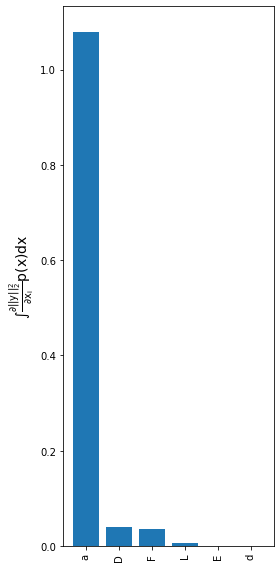

In [85]:
fig = plt.figure('sensitivity', figsize=[4, 8])
ax = fig.add_subplot(111)
ax.set_ylabel(r'$\int\frac{\partial ||y||^2_2}{\partial x_i}p({\bf x})d{\bf x}$', fontsize=14)
ax.bar(range(V_i.size), height = V_i[idx].flatten())
ax.set_xticks(range(V_i.size))
ax.set_xticklabels(params_ordered)
plt.xticks(rotation=90)
plt.tight_layout()

## Higher dimensions - HIV model

Six input dimensions is relatively mild, which can still be handled by Stochastic Collocation methods. Here we will look at a HIV model, taken from the [Active Subspace data set repository](https://github.com/paulcon/as-data-sets). It models the T-cell count during different stages of the disease, and has 27 input parameters spread out over 7 coupled ODEs.

### HIV model

From [here](https://github.com/paulcon/as-data-sets/blob/master/HIV/HIV.ipynb) we find the following description of the model, see also [4]. The 7 coupled ordinary differential equations are given by:

$$
\begin{align}
\frac{dT}{dt} &= s_1 + \frac{p_1}{C_1+V}TV - \delta_1T - (K_1V + K_2M_I)T,\\
\frac{dT_I}{dt} &= \psi(K_1V + K_2M_I)T + \alpha_1T_L-\delta_2T_I-K_3T_ICTL,\\
\frac{dT_L}{dt} &= (1-\psi)(K_1V+K_2M_I)T-\alpha_1T_L-\delta_3T_L,\\
\frac{dM}{dt} &= s_2+K_4MV-K_5MV-\delta_4M,\\
\frac{dM_I}{dt} &= K_5MV-\delta_5M_I-K_6M_ICTL,\\
\frac{dCTL}{dt} &= s_3 + (K_7T_I+K_8M_I)CTL-\delta_6CTL,\\
\frac{dV}{dt} &= K_9T_I+K_{10}M_I-K_{11}TV-(K_{12}+K_{13})MV-\delta_7V,
\end{align}
$$

where $T(t)$ is the CD4$^+$ T-cell population, $T_I$ is the actively infected T-cell population, $T_L$ represents latently-infected T-cells, $M$ is macrophages, $M_I$ is infected macrophages, $CTL$ is cytotoxic lymphocytes, and $V$ is virions. The model's 27 parameters are summarized in the table below.

Parameter|Nominal Value|Distribution (U(min, max))
:-------:|:-----------:|:-------------:
$s_1$|  10 |  U(9.75, 10.25)
$s_2$|   .15 |  U(.14625, .15375)
$s_3$|   5  | U(4.875, 5.125)
$p_1$|   .2 |  U(.195, .205)
$C_1$|   55.6  | U(54.21, 56.99)
$K_1$|   3.87e-3 |  U(3.77325e-3, 3.96675e-3)
$K_2$|   1e-6  | U(.975e-6, 1.025e-6)
$K_3$|   4.5e-4 |  U(4.3875e-4, 4.6125e-4)
$K_4$|   7.45e-4 |  U(7.26375e-4, 7.63625e-4)
$K_5$|   5.22e-4 |  U(5.0895e-4, 5.3505e-4)
$K_6$|   3e-6  | U(2.925e-6, 3.075e-6)
$K_7$|   3.3e-4  | U(3.2175e-4, 3.3825e-4)
$K_8$|   6e-9  | U(5.85e-9, 6.15e-9)
$K_9$|   .537 |  U(.523575, .550425)
$K_{10}$|   .285 |  U(.277875, .292125)
$K_{11}$|   7.79e-6 |  U(7.59525e-6, 7.98475e-6)
$K_{12}$|   1e-6  | U(.975e-6, 1.025e-6)
$K_{13}$|   4e-5   |U(3.9e-5, 4.1e-5)
$\delta_1$|   .01 |  U(.00975, .01025)
$\delta_2$|   .28  | U(.273, .287)
$\delta_3$|   .05  | U(.04875, .05125)
$\delta_4$|   .005  | U(.004875, .005125)
$\delta_5$|   .005 |  U(.004875, .005125)
$\delta_6$|   .015 |  U(.014625, .015375)
$\delta_7$|   2.39 |  U(2.33025, 2.44975)
$\alpha_1$|   3e-4 |  U(2.925e-4, 3.075e-4)
$\psi$|   .97 |  U(.94575, .99425)

The limits on the uniform distributions are 2.5% above and below the nominal values. 


Below we will generate 1000 samples from this model. We could again use EasyVVUQ for this purpose, but since the model is computationally inexpensive, we'll directly generate the training data using the [python script](https://github.com/paulcon/as-data-sets/blob/master/HIV/HIV_model.py) from the active subspace dataset repo. 

/home/wouter/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1014: UserWarning: vode: Repeated convergence failures. (Perhaps bad Jacobian supplied or wrong choice of MF or tolerances.)
  self.messages.get(istate, unexpected_istate_msg)))


Text(0.5, 1.0, 'Representative Solutions for T(t)')

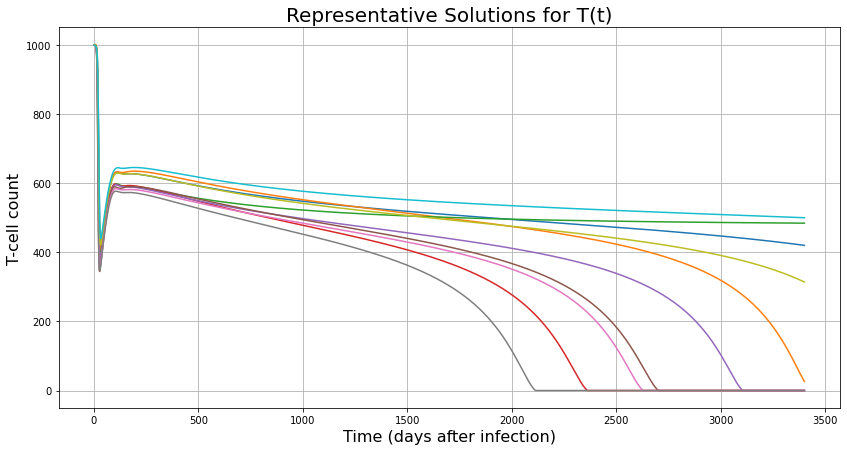

In [50]:
from HIV_model import *

#Nominal Parameter Values
nominal = np.array([10, .15, 5, .2, 55.6, 3.87e-3, 1e-6, 4.5e-4, 7.45e-4, 5.22e-4, 3e-6,\
    3.3e-4, 6e-9, .537, .285, 7.79e-6, 1e-6, 4e-5, .01, .28, .05, .005, .005, .015, 2.39,\
    3e-4, .97])

#Lower and upper parameter limits
xl = .975*nominal; xu = 1.025*nominal

#Number of random points to use
N = 1000

#Normalized parameter values
XX = np.random.uniform(-1, 1, (N, len(xl)))
#Unnormalized parameter values
p = .5*((np.diag(xu - xl)).dot(XX.T) + xu[:,None] + xl[:,None]).T

#Times at which to find the quantity of interest initially
times = np.linspace(1, 3400, 3400)

#Each row of f contains T(t) for t in times using parameters in the corresponding row of p
f = Tcells(p, times)

#Plot the first 10 solutions as example solutions
plt.figure(figsize=(14, 7))
for i in range(10): plt.plot(times, f[i])
plt.grid(True); plt.xlabel('Time (days after infection)', fontsize=16)
plt.ylabel('T-cell count', fontsize=16)
plt.title('Representative Solutions for T(t)', fontsize=20)

The classical active subspace method only functions with scalar output values. Deep active subspaces can handle multi-dimensional outputs, but here we'll try to replicate the sensitivity results from ([source](https://github.com/paulcon/as-data-sets/blob/master/HIV/HIV.ipynb)), when training on the data of the final day ($t=3400$). From the classical active-subspace results we already know the model has a one-dimensional active subspace, so we'll set `d=1`.

In [51]:
surr_campaign = es.Campaign()
surrogate = es.methods.DAS_Surrogate()
d = 1
# train on data of the final day
surrogate.train(XX, f[:, -1].reshape([-1, 1]), d, n_iter=10000, n_layers=4, n_neurons=100, test_frac = 0.0)

Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  1000/1000 samples to train the ML model
Neural net parameters
Number of layers = 4
Number of features = 27
Loss function = squared
Number of neurons per hidden layer = 100
Number of output neurons = 1
Activation hidden layers = tanh
Activation output layer = linear
This neural network has 10428 weights.
Training Deep Active Subspace Neural Network...
Batch 0 learning rate 0.001 loss: 1.3491732861862755
Batch 1000 learning rate 0.001 loss: 0.006749978069699579
Batch 2000 learning rate 0.001 loss: 0.004602163676943521
Batch 3000 learning rate 0.001 loss: 0.0036516970579910783
Batch 4000 learning rate 0.001 loss: 0.003705050056164225
Batch 5000 learning rate 0.001 loss: 0.003995793608346222
Batch 6000 learning rate 0.001 loss: 0.008784051322975559
Batch 7000 learning rate 0.001 loss: 0.005123883524230225
Batch 8000 learning rate 0.001 loss: 0.0030077456558278495
Batch 9000 learning rate 0.001 loss: 0.0061934387026152

Creating DAS_analysis object
Parameters ordered from most to least important:
[[ 8 24 21  9 23 13  1 14 11 22  2 10  3  4 26  0  5  7 18 19  6 15 25 17
  20 16 12]]


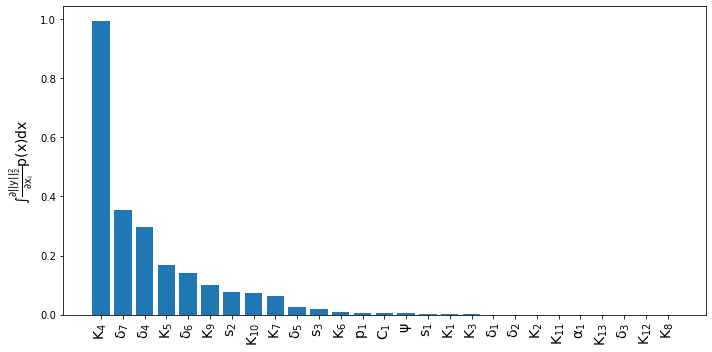

In [53]:
analysis = es.analysis.DAS_analysis(surrogate)

idx, V_i = analysis.sensitivity_measures(XX)

# Parameter names
param_names = np.array([r'$s_1$', r'$s_2$', r'$s_3$', r'$p_1$', r'$C_1$', r'$K_1$', r'$K_2$', r'$K_3$',
               r'$K_4$', r'$K_5$', r'$K_6$', r'$K_7$', r'$K_8$', r'$K_9$', r'$K_{10}$',
               r'$K_{11}$', r'$K_{12}$', r'$K_{13}$', r'$\delta_1$', r'$\delta_2$',
               r'$\delta_3$', r'$\delta_4$', r'$\delta_5$', r'$\delta_6$', r'$\delta_7$', r'$\alpha_1$',
               r'$\psi$'])

fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(111)
ax.set_ylabel(r'$\int\frac{\partial ||y||^2_2}{\partial x_i}p({\bf x})d{\bf x}$', fontsize=14)
ax.bar(range(V_i.size), height = V_i[idx].flatten())
ax.set_xticks(range(V_i.size))
ax.set_xticklabels(param_names[idx[0]], fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()

Compare this to the sensitivity measure from the classical active subspace method. The figure below ([source](https://github.com/paulcon/as-data-sets/blob/master/HIV/HIV.ipynb)) plots the entries of the first eigenvector of the gradient matrix $C$. The higher the **absolute** values of these entries, the more important the corresponding parameter. The order of the important variables should match the order you've obtained above fairly well.

 ![](images/AS_weights.png)

## Final remarks

* Note that the Deep Active Subspaces had no trouble handling a 27 dimensional input space. We only recently started to look at this method in VECMA, but we expect that for instance a 100 dimensional space would also not pose a problem, in the sense that you can at least apply the method to such a large space without numerical issues. This would not be possible with isotropic sparse grids.

* That said, we have still several questions regarding the use of this method, such as the data requirement (neural nets are data hungry, how does this stack up to e.g. GPs in high dimensional settings), the performance of DAS surrogates vs standard ANNs, how to the sensitivity measure stacks up to Sobol sensitivity indices etc.

## References

[1] Constantine, P. G., Dow, E., & Wang, Q. (2014). Active subspace methods in theory and practice: applications to kriging surfaces. SIAM Journal on Scientific Computing, 36(4), A1500-A1524.

[2] Tripathy, R., & Bilionis, I. (2019, February). Deep active subspaces: A scalable method for high-dimensional uncertainty propagation. In ASME 2019 International Design Engineering Technical Conferences and Computers and Information in Engineering Conference. American Society of Mechanical Engineers Digital Collection.

[3] Sobol, I. M., & Kucherenko, S. (2010). Derivative based global sensitivity measures. Procedia-Social and Behavioral Sciences, 2(6), 7745-7746.

[4] T. Loudon and S. Pankavich. _Mathematical Analysis and Dynamic Active Subspaces for a Long term model of HIV_. arXiv:1604.04588, 2016

[5] Edeling, W., Arabnejad, H., Sinclair, R., Suleimenova, D., Gopalakrishnan, K., Bosak, B., ... & Coveney, P. V. (2021). The impact of uncertainty on predictions of the CovidSim epidemiological code. Nature Computational Science, 1(2), 128-135.